In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import base64
import datetime
import requests
import pandas as pd
import numpy as np
import sqlite3

In [2]:
clientID = ''
clientSecret ='' 

**Master Class**

In [31]:
class SpotifyAPI(object):
    sampleSongs = {}
    dislikedSongs = {}
    likedSongs = {}
    accessToken = None
    dislikePlaylistURI = None
    likePlaylistURI = None
    samplePlaylistURI = None
    data = []
    target = []
    accessTokenExpires = datetime.datetime.now()
    accessTokenDidExpire = True
    clientID = None
    clientSecret = None
    tokenURL = "https://accounts.spotify.com/api/token"
    
    def __init__(self, clientID, clientSecret, sampleSongs, dislikedSongs, likedSongs, samplePlaylistURI, likePlaylistURI, dislikePlaylistURI, data, target, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.clientID = clientID
        self.clientSecret = clientSecret
        self.dislikedSongs = dislikedSongs
        self.likedSongs = likedSongs
        self.sampleSongs = sampleSongs
        self.samplePlaylistURI = samplePlaylistURI
        self.likePlaylistURI = likePlaylistURI
        self.dislikePlaylistURI = dislikePlaylistURI
        self.data = data
        self.target = target
  
    def getClientCredentials(self):
        clientID = self.clientID
        clientSecret = self.clientSecret
        if clientSecret == None or clientID == None:
            raise Exception("You must set clientID and clientSecret")
        clientCreds = f"{clientID}:{clientSecret}"
        clientCreds64 = base64.b64encode(clientCreds.encode())
        return clientCreds64.decode()
    
    def getTokenData(self):
        return {"grant_type": "client_credentials", "scope": "playlist-modify-private playlist-modify-public user-library-read playlist-read-private"}
    
    def getTokenHeader(self):
        clientCreds64 = self.getClientCredentials()
        return {"Authorization": f"Basic {clientCreds64}"}
        
    def authenticateToken(self):
        tokenURL = self.tokenURL
        tokenData = self.getTokenData()
        tokenHeader = self.getTokenHeader()
        r = requests.post(tokenURL, data = tokenData, headers = tokenHeader)
        print(r.json())
        if r.status_code not in range(200, 299):
            return False
        data = r.json()
        now = datetime.datetime.now()
        accessToken = data['access_token']
        expires_in = data['expires_in']
        expires = now + datetime.timedelta(seconds = expires_in)
        self.accessToken = accessToken
        self.accessTokenExpires = expires
        self.accessTokenDidExpire = expires < now
    
    def getSongs(self):
        dislikeQuery = "https://api.spotify.com/v1/playlists/{}/tracks".format(self.dislikePlaylistURI)
        response = requests.get(dislikeQuery, headers={"Authorization": "Bearer {}".format(client.accessToken)}).json()
        for i in response["items"]:
            self.dislikedSongs[str(i["track"]["name"]) + " - " + str(i["track"]["artists"][0]["name"])] = i["track"]["id"]
            
        likeQuery = "https://api.spotify.com/v1/playlists/{}/tracks".format(self.likePlaylistURI)
        response = requests.get(likeQuery, headers={"Authorization": "Bearer {}".format(client.accessToken)}).json()
        for i in response["items"]:
            self.likedSongs[str(i["track"]["name"]) + " - " + str(i["track"]["artists"][0]["name"])] = i["track"]["id"]
            
        sampleQuery = "https://api.spotify.com/v1/playlists/{}/tracks".format(self.samplePlaylistURI)
        response = requests.get(sampleQuery, headers={"Authorization": "Bearer {}".format(client.accessToken)}).json()
        for i in response["items"]:
            self.sampleSongs[str(i["track"]["name"]) + " - " + str(i["track"]["artists"][0]["name"])] = i["track"]["id"]
            
        # Store in database
        # Front end development
        # Normalize data points
        # Elbow method
        # How to determine best k value
        # Feature engineering
        # Build another class
            
    def getAudioFeaturesDislike(self, dataFrame):
        for keys in self.dislikedSongs.keys():
            query = "https://api.spotify.com/v1/audio-features/" + self.dislikedSongs[keys]
            response = requests.get(query, headers={"Authorization": "Bearer {}".format(client.accessToken)}).json()
            res = {key: response[key] for key in response.keys() & {'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'}}
            dataFrame = dataFrame.append({'Track Title and Artist': keys, 'Danceability': res['danceability'],
                                     'Energy': res['energy'], 'Key': res['key'],
                                     'Loudness': res['loudness'], 'Mode': res['mode'],
                                     'Speechiness': res['speechiness'], 'Acousticness': res['acousticness'],
                                          'Instrumentalness': res['instrumentalness'], 'Liveness': res['liveness'],
                                          'Valence': res['valence'], 'Tempo': res['tempo']}, ignore_index = True)
            
        return dataFrame
    
    def getAudioFeaturesLike(self, dataFrame):
        for keys in self.likedSongs.keys():
            query = "https://api.spotify.com/v1/audio-features/" + self.likedSongs[keys]
            response = requests.get(query, headers={"Authorization": "Bearer {}".format(client.accessToken)}).json()
            res = {key: response[key] for key in response.keys() & {'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'}}
            dataFrame = dataFrame.append({'Track Title and Artist': keys, 'Danceability': res['danceability'],
                                     'Energy': res['energy'], 'Key': res['key'],
                                     'Loudness': res['loudness'], 'Mode': res['mode'],
                                     'Speechiness': res['speechiness'], 'Acousticness': res['acousticness'],
                                          'Instrumentalness': res['instrumentalness'], 'Liveness': res['liveness'],
                                          'Valence': res['valence'], 'Tempo': res['tempo']}, ignore_index = True)
            
        return dataFrame
    
    def formulateData(self):
        for keys in self.dislikedSongs.keys():
            query = "https://api.spotify.com/v1/audio-features/" + self.dislikedSongs[keys]
            response = requests.get(query, headers={"Authorization": "Bearer {}".format(client.accessToken)}).json()
            res = {key: response[key] for key in response.keys() & {'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'}} 
            temp = [res['danceability'], res['energy'], res['key'], res['loudness'], res['mode'], res['speechiness'], res['acousticness'], res['instrumentalness'], res['liveness'], res['valence'], res['tempo']]
            self.data.append(temp)
            
        for keys in self.likedSongs.keys():
            query = "https://api.spotify.com/v1/audio-features/" + self.likedSongs[keys]
            response = requests.get(query, headers={"Authorization": "Bearer {}".format(client.accessToken)}).json()
            res = {key: response[key] for key in response.keys() & {'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'}} 
            temp = [res['danceability'], res['energy'], res['key'], res['loudness'], res['mode'], res['speechiness'], res['acousticness'], res['instrumentalness'], res['liveness'], res['valence'], res['tempo']]
            self.data.append(temp)
        
        self.target = np.array(([0]*(len(self.dislikedSongs.keys()))) + ([1]*(len(self.likedSongs.keys()))))
        return self.data, self.target
    
    def visualizeData(self):
        X_train, X_test, Y_train, Y_test = train_test_split(np.array(self.data), np.array(self.target), random_state = 0)
        spotifyDataSet = pd.DataFrame(X_train, columns = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo'])
        pd.plotting.scatter_matrix(spotifyDataSet, c = Y_train, figsize = (15,15), marker = 'o', hist_kwds = {"bins": 20}, alpha = 0.8)
        
    def makePrediction(self):
        X_train, X_test, Y_train, Y_test = train_test_split(np.array(self.data), np.array(self.target), random_state = 0)
        knn = KNeighborsClassifier(n_neighbors = 2)
        knn.fit(X_train, Y_train)
        for keys in self.sampleSongs.keys():
            query = "https://api.spotify.com/v1/audio-features/" + self.sampleSongs[keys]
            response = requests.get(query, headers={"Authorization": "Bearer {}".format(client.accessToken)}).json()
            res = {key: response[key] for key in response.keys() & {'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'}} 
            temp = [res['danceability'], res['energy'], res['key'], res['loudness'], res['mode'], res['speechiness'], res['acousticness'], res['instrumentalness'], res['liveness'], res['valence'], res['tempo']]
            X_new = np.array([temp])
            prediction = knn.predict(X_new)
            if prediction == 0:
                print("You probably won't like: " + keys)
            else:
                print("You'll probably like: " + keys)
                
    


In [32]:
client = SpotifyAPI(clientID, clientSecret, {}, {}, {}, "37i9dQZEVXbfMjsPvoMXmt", "0VkTPDzsR91iQdjNBg6W9o", "1GXJtyfULnAAIQy4HKTDyQ", [], [])
client.authenticateToken()

{'access_token': 'BQANfwcPlK8l3AMYpqzoXhutOCf7n-Ya2tk-NV6phGvlGQko1L_xMGgwS5gDWD0XRmgOnLbotsMhAKquPAWfSV0dZ5xMwaH5kg5qHhkvJItf9qE1AOlXI-IFoDj_dSnxvPMSItalsVyuwQD7jdg6q3vZoqyT7nNRXu9C4XWj7Q_IG758ULAdpYetx_xc_k9P6jaM0w', 'token_type': 'Bearer', 'expires_in': 3600, 'scope': 'playlist-read-private user-library-read playlist-modify-private playlist-modify-public'}


In [33]:
client.getSongs()

**Pull Data**

In [34]:
dataFrame = pd.DataFrame(columns=['Track Title and Artist', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo'])
client.getAudioFeaturesDislike(dataFrame)

,Track Title and Artist,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,I Know What You Did Last Summer - Shawn Mendes,0.687,0.761,9,-4.582,0,0.0876,0.10200,0,0.1470,0.743,113.939
1,Stressed Out - Twenty One Pilots,0.734,0.637,4,-5.677,0,0.1410,0.04620,0.000023,0.0602,0.648,169.977
2,Dance Monkey - Tones And I,0.824,0.588,6,-6.400,0,0.0924,0.69200,0.000104,0.1490,0.513,98.027
3,Scars To Your Beautiful - Alessia Cara,0.573,0.739,0,-5.740,1,0.1290,0.02850,0,0.1110,0.451,97.085
4,Believer - Imagine Dragons,0.776,0.780,10,-4.374,0,0.1280,0.06220,0,0.0810,0.666,124.949
5,Cheap Thrills - Sia,0.628,0.698,6,-5.608,0,0.1050,0.04720,0.00143,0.0907,0.732,89.976
6,Shape of You - Ed Sheeran,0.825,0.652,1,-3.183,0,0.0802,0.58100,0,0.0931,0.931,95.977
7,Heathens - Twenty One Pilots,0.732,0.396,4,-9.348,0,0.0286,0.08410,0.000036,0.1050,0.548,90.024
8,Havana (feat. Young Thug) - Camila Cabello,0.765,0.523,2,-4.333,1,0.0300,0.18400,0.000036,0.1320,0.394,104.988
9,Alone - Alan Walker,0.673,0.914,10,-3.962,1,0.0496,0.22900,0.000478,0.1860,0.183,97.021


In [35]:
client.getAudioFeaturesLike(dataFrame)

,Track Title and Artist,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,Parking Lots - Plums,0.488,0.763,1,-5.331,0,0.0300,0.0203,0.370000,0.3430,0.716,155.663
1,She Ain't You - Chris Brown,0.634,0.716,2,-6.502,1,0.1280,0.0341,0.000000,0.0877,0.619,91.039
2,Slide (feat. Frank Ocean & Migos) - Calvin Harris,0.736,0.795,1,-3.299,0,0.0545,0.4980,0.000001,0.2540,0.511,104.066
3,"Cash Out (feat. ScHoolboy Q, PARTYNEXTDOOR & D...",0.722,0.790,4,-4.867,0,0.2410,0.1520,0.000000,0.0349,0.434,94.965
4,Love$ick (feat. A$AP Rocky) - Mura Masa,0.625,0.763,8,-4.997,0,0.1290,0.1470,0.010600,0.2140,0.721,88.753
...,...,...,...,...,...,...,...,...,...,...,...,...
66,Strange Things - B. Lewis,0.609,0.668,0,-6.352,1,0.0352,0.0432,0.000067,0.2410,0.503,74.059
67,New Money (with 21 Savage) - Calvin Harris,0.875,0.831,11,-5.991,1,0.0772,0.2780,0.000017,0.0877,0.742,91.990
68,Touch The Sky - Kanye West,0.552,0.846,9,-4.912,1,0.3420,0.0114,0.000000,0.3090,0.554,98.560
69,Forrest Gump - Frank Ocean,0.701,0.417,6,-7.818,0,0.0329,0.0888,0.000648,0.3750,0.186,95.003


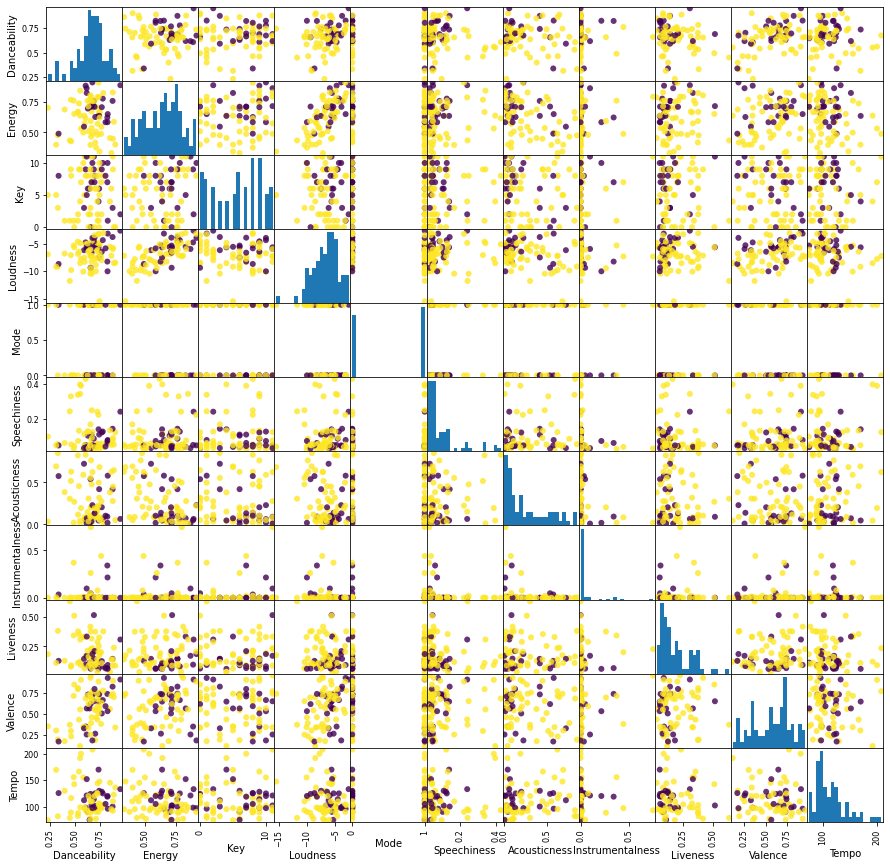

In [36]:
client.formulateData()
client.visualizeData()

**Make Predictions**

In [162]:
client.makePrediction()

You'll probably like: Let It Breathe - Joey Bada$$
You'll probably like: Mount Olympus - Femdot
You probably won't like: Mortal Kombat - Danny Dwyer
You probably won't like: Numb - DJ YUKI Remix - Marshmello
You probably won't like: BEAUTIFUL (feat. Future & SZA) - DJ Khaled
You'll probably like: The Reason - James Vickery
You probably won't like: Leave It On The Dancefloor - Hope Tala
You probably won't like: Landslide - Gus Dapperton
You probably won't like: No No No - Tayc
You'll probably like: I Want You - John Morales M+M Pianopella Mix - Marvin Gaye
You'll probably like: Falling Behind - Laufey
You'll probably like: fun out of it - Johnny Orlando
You'll probably like: Infinitely Tall - Charlie Burg
You'll probably like: Santuário Do Morro - Elis Regina
You'll probably like: 2 DOGS 1 LEASH - Noah Guy
You'll probably like: Camp Anonymous - Cautious Clay
You'll probably like: Lady Love - Thee Sacred Souls
You'll probably like: Maestro - Walker
You'll probably like: For Tonight (feat